# Homework 4
# Cohort 1 Group 4
# Authors: Ashutosh Ekade, Zechen Liu, Jessica Ghai, Yuetong Li

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.simplefilter('once', category=Warning)

In [2]:
from_date = datetime(month=2, day=28, year=2024)
expiry_date = datetime(month=6, day=21, year=2024)

In [3]:
T = round((expiry_date - from_date).days / 365, 5)
print("T (rounded to 5 decimals): {} yrs".format(T))

T (rounded to 5 decimals): 0.31233 yrs


In [4]:
df = pd.read_csv('spx_quotedata-2024-02-08_NoZerosNoW.csv', header=None)
print(df.shape)
underlying_price = float(df.iloc[0,1])
print("Underlying Last Close: {}".format(underlying_price))
df = pd.read_csv('spx_quotedata-2024-02-08_NoZerosNoW.csv', skiprows=2)
# print(df.head())
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])
df = df[df['Expiration Date']==expiry_date]
print(df.shape)
print(df.head())

(3319, 22)
Underlying Last Close: 4997.9102
(259, 22)
     Expiration Date               Calls  Last Sale   Net     Bid     Ask  \
1449      2024-06-21  SPX240621C00200000    4753.89  0.00  4774.1  4782.8   
1450      2024-06-21  SPX240621C00400000    4151.70  0.00  4578.0  4586.7   
1451      2024-06-21  SPX240621C00600000    4159.57  0.00  4382.0  4390.5   
1452      2024-06-21  SPX240621C00800000    3906.61  0.00  4185.6  4194.3   
1453      2024-06-21  SPX240621C01000000    3983.12 -6.23  3989.5  3998.2   

      Volume      IV  Delta  Gamma  ...                Puts  Last Sale.1  \
1449       0  2.1294    1.0    0.0  ...  SPX240621P00200000         0.03   
1450       0  1.6333    1.0    0.0  ...  SPX240621P00400000         0.05   
1451       0  1.3574    1.0    0.0  ...  SPX240621P00600000         0.05   
1452       0  1.1518    1.0    0.0  ...  SPX240621P00800000         0.07   
1453     150  1.0076    1.0    0.0  ...  SPX240621P01000000         0.07   

      Net.1  Bid.1  Ask.1 

In [5]:
df["C_K_mid"] = (df["Bid"] + df["Ask"]) / 2
df["P_K_mid"] = (df["Bid.1"] + df["Ask.1"]) / 2
df["C_K_m_P_K_m"] = df["C_K_mid"] - df["P_K_mid"]
df["Spot"] = underlying_price
print(df.head())

     Expiration Date               Calls  Last Sale   Net     Bid     Ask  \
1449      2024-06-21  SPX240621C00200000    4753.89  0.00  4774.1  4782.8   
1450      2024-06-21  SPX240621C00400000    4151.70  0.00  4578.0  4586.7   
1451      2024-06-21  SPX240621C00600000    4159.57  0.00  4382.0  4390.5   
1452      2024-06-21  SPX240621C00800000    3906.61  0.00  4185.6  4194.3   
1453      2024-06-21  SPX240621C01000000    3983.12 -6.23  3989.5  3998.2   

      Volume      IV  Delta  Gamma  ...  Ask.1  Volume.1    IV.1  Delta.1  \
1449       0  2.1294    1.0    0.0  ...   0.10         0  1.5438  -0.0001   
1450       0  1.6333    1.0    0.0  ...   0.10         0  1.2015  -0.0001   
1451       0  1.3574    1.0    0.0  ...   0.15         0  1.0342  -0.0001   
1452       0  1.1518    1.0    0.0  ...   0.15         0  0.8942  -0.0002   
1453     150  1.0076    1.0    0.0  ...   0.20       156  0.8154  -0.0003   

      Gamma.1  Open Interest.1  C_K_mid  P_K_mid  C_K_m_P_K_m       Spot  

In [6]:
X = df[['Strike', 'Spot']]
y = df['C_K_m_P_K_m']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            C_K_m_P_K_m   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.628e+09
Date:                Mon, 26 Feb 2024   Prob (F-statistic):               0.00
Time:                        19:08:56   Log-Likelihood:                 84.931
No. Observations:                 259   AIC:                            -165.9
Df Residuals:                     257   BIC:                            -158.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Strike        -0.9805   9.99e-06  -9.81e+04      0.0

In [7]:
r_implied = (- np.log(- model.params["Strike"])) / T
y_implied = (- np.log(model.params["Spot"])) / T
print("R-Implied: {:.5f} % \nY_Implied: {:.5f} %".format(r_implied*100, y_implied*100))

R-Implied: 6.29048 % 
Y_Implied: 1.49699 %


In [8]:
R_T = np.exp(- r_implied * T)
F_T = underlying_price * np.exp((r_implied - y_implied)*T)
print("RT: {:.5f} \nFT: {:.5f}\nSpot: {}".format(R_T, F_T, underlying_price))

RT: 0.98054 
FT: 5073.29934
Spot: 4997.9102


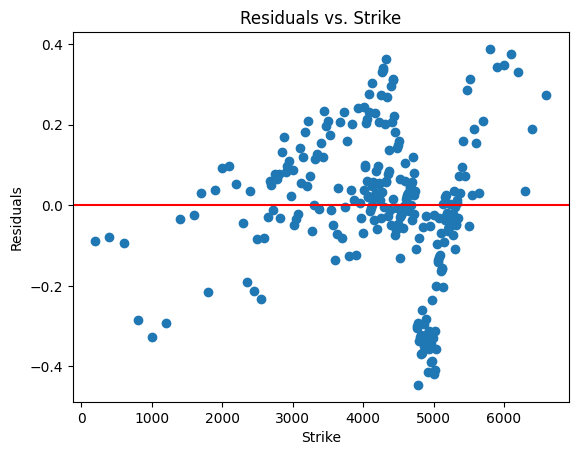

In [9]:
residuals = model.resid
plt.scatter(df['Strike'], residuals)
plt.xlabel('Strike')
plt.ylabel('Residuals')
plt.title('Residuals vs. Strike')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [10]:
def black_scholes_price(S0, K, r, y, T, option_type, sigma):
    d1 = np.log((S0 / K)) + ((r - y + (sigma**2)*0.5) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "C":
        price = S0 * np.exp(- y * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "P":
        price = -S0 * np.exp(-y * T) * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(-d2)
    return price

def vega(S0, K, r, y, T, sigma):
    d1 = np.log((S0 / K)) + ((r - y + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    vega = S0*(norm.pdf(d1))*(np.sqrt(T))
    return vega

def imp_vol(S0, K, T, r, y, market, flag, vega_initial):
    e = 10e-14
    x0 = vega_initial
    def newtons_method(S0, K, T, r, y, market, flag, x0, e):
        delta = black_scholes_price(S0, K, r, y, T, flag, x0) - market
        while delta > e:
            x0 = (x0 - (black_scholes_price(S0, K, r, y, T, flag, x0) - market) / vega(S0, K, r, y, T, x0))
            delta = abs(black_scholes_price(S0, K, r, y, T, flag, x0) - market)
        return x0
    sig =  newtons_method(S0, K, T, r, y, market, flag, x0, e)
    return sig*100


S0 = underlying_price
K = 5000
market = df[df["Strike"]==K].loc[:, 'P_K_mid'].values[0]
flag = 'P'
vega_initial = 0.1872818
iv = imp_vol(S0, 5000, T, r_implied, y_implied, market, flag, vega_initial)
print("################ Newton Raphson Method ##################")
print('The implied volatility is: {:.7f} %'.format(iv))

################ Newton Raphson Method ##################
The implied volatility is: 13.6500200 %


In [11]:
strikes_of_interest = []
for i in range(int(5000 * (1 - 0.2 * np.sqrt(T))), int(5000 * (1 + 0.2 * np.sqrt(T)))):
    if i % 10 == 0:
        strikes_of_interest.append(i)

In [12]:
sub_df = df[df.Strike.map(lambda x: np.isin(x, strikes_of_interest).all())]
print(sub_df.shape)

(96, 26)


In [13]:
X = sub_df[['Strike', 'Spot']]
y = sub_df['C_K_m_P_K_m']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            C_K_m_P_K_m   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.307e+08
Date:                Mon, 26 Feb 2024   Prob (F-statistic):          1.72e-309
Time:                        19:08:57   Log-Likelihood:                 46.871
No. Observations:                  96   AIC:                            -89.74
Df Residuals:                      94   BIC:                            -84.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Strike        -0.9806   5.39e-05  -1.82e+04      0.0

In [14]:
r_implied = (- np.log(- model.params["Strike"])) / T
y_implied = (- np.log(model.params["Spot"])) / T
print("R-Implied: {:.5f} % \nY_Implied: {:.5f} %".format(r_implied*100, y_implied*100))

R-Implied: 6.27747 % 
Y_Implied: 1.49019 %


In [15]:
R_T = np.exp(- r_implied * T)
F_T = underlying_price * np.exp((r_implied - y_implied)*T)
print("RT: {:.5f} \nFT: {:.5f}\nSpot: {}".format(R_T, F_T, underlying_price))

RT: 0.98058 
FT: 5073.20094
Spot: 4997.9102


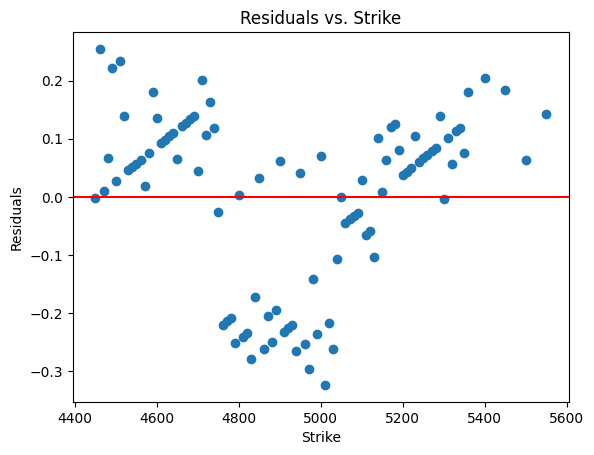

In [16]:
residuals = model.resid
plt.scatter(sub_df['Strike'], residuals)
plt.xlabel('Strike')
plt.ylabel('Residuals')
plt.title('Residuals vs. Strike')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [17]:
S0 = underlying_price
K = 5000
market = sub_df[sub_df["Strike"]==K].loc[:, 'P_K_mid'].values[0]
flag = 'P'
vega_initial = 0.1872818
iv = imp_vol(S0, 5000, T, r_implied, y_implied, market, flag, vega_initial)
print("################ Newton Raphson Method ##################")
print('The implied volatility is: {:.7f} %'.format(iv))

################ Newton Raphson Method ##################
The implied volatility is: 13.6459227 %


                            WLS Regression Results                            
Dep. Variable:      Parity_Constraint   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.285e+08
Date:                Mon, 26 Feb 2024   Prob (F-statistic):          5.82e-316
Time:                        19:08:57   Log-Likelihood:                 64.989
No. Observations:                  96   AIC:                            -122.0
Df Residuals:                      92   BIC:                            -111.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Strike        -0.9809      0.000  -7005.941      0.0

/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_1909/1542473142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['C_var'] = (sub_df['Ask'] - sub_df['Bid'])**2
/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_1909/1542473142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['P_var'] = (sub_df['Ask.1'] - sub_df['Bid.1'])**2
/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_1909/1542473142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

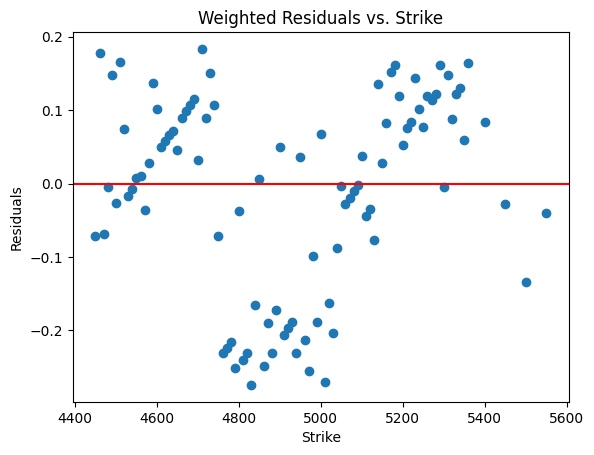

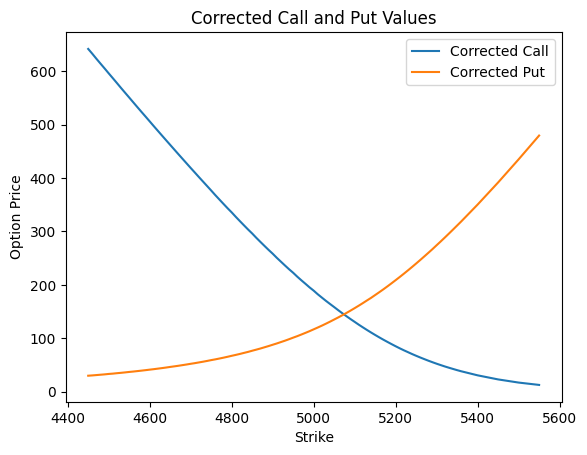

In [18]:
sub_df['C_var'] = (sub_df['Ask'] - sub_df['Bid'])**2
sub_df['P_var'] = (sub_df['Ask.1'] - sub_df['Bid.1'])**2

sub_df['C_weight'] = 1 / sub_df['C_var']
sub_df['P_weight'] = 1 / sub_df['P_var']

sub_df['Parity_Constraint'] = sub_df['C_K_mid'] - sub_df['P_K_mid'] - model.params['Strike'] * model.params['Spot'] * T

X = sub_df[['Strike', 'Spot', 'C_weight', 'P_weight']]
y = sub_df['Parity_Constraint']

model_weighted = sm.WLS(y, X, weights=(sub_df['C_weight'] + sub_df['P_weight'])).fit()

sub_df['C_corrected'] = sub_df['C_K_mid'] - model_weighted.params['Strike'] * model_weighted.params['Spot'] * T
sub_df['P_corrected'] = sub_df['P_K_mid'] + model_weighted.params['Strike'] * model_weighted.params['Spot'] * T

print(model_weighted.summary())

residuals_weighted = model_weighted.resid
plt.scatter(sub_df['Strike'], residuals_weighted)
plt.xlabel('Strike')
plt.ylabel('Residuals')
plt.title('Weighted Residuals vs. Strike')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

plt.plot(sub_df['Strike'], sub_df['C_corrected'], label='Corrected Call')
plt.plot(sub_df['Strike'], sub_df['P_corrected'], label='Corrected Put')
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.title('Corrected Call and Put Values')
plt.legend()
plt.show()

In [19]:
sub_df['C_error'] = (sub_df['C_corrected'] - sub_df['C_K_mid']) ** 2
sub_df['P_error'] = (sub_df['P_corrected'] - sub_df['P_K_mid']) ** 2

sub_df['C_weighted_error'] = sub_df['C_error'] * sub_df['C_weight']
sub_df['P_weighted_error'] = sub_df['P_error'] * sub_df['P_weight']

total_weighted_error = sub_df['C_weighted_error'].sum() + sub_df['P_weighted_error'].sum()

total_weights = sub_df['C_weight'].sum() + sub_df['P_weight'].sum()

weighted_sum_squared_errors = total_weighted_error / total_weights

print("Weighted Sum of Squared Errors for the resulting [C_corrected, P_corrected] pair: {:.7f}".format(weighted_sum_squared_errors))

Weighted Sum of Squared Errors for the resulting [C_corrected, P_corrected] pair: 0.0930499


/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_1909/1621708431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['C_error'] = (sub_df['C_corrected'] - sub_df['C_K_mid']) ** 2
/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_1909/1621708431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['P_error'] = (sub_df['P_corrected'] - sub_df['P_K_mid']) ** 2
/var/folders/44/r2pt84y14r968g9_vxmvrlxh0000gn/T/ipykernel_1909/1621708431.py:4: SettingWithCopyWarning: 
A value is try

In [20]:
model_weighted_hetero = sm.WLS(y, X, weights=(sub_df['C_weight'] + sub_df['P_weight'])).fit()

print(model_weighted_hetero.summary())

                            WLS Regression Results                            
Dep. Variable:      Parity_Constraint   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.285e+08
Date:                Mon, 26 Feb 2024   Prob (F-statistic):          5.82e-316
Time:                        19:08:57   Log-Likelihood:                 64.989
No. Observations:                  96   AIC:                            -122.0
Df Residuals:                      92   BIC:                            -111.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Strike        -0.9809      0.000  -7005.941      0.0

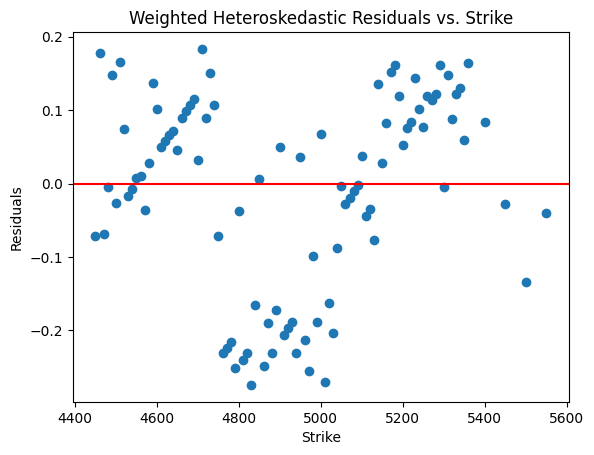

In [21]:
residuals_weighted_hetero = model_weighted_hetero.resid
plt.scatter(sub_df['Strike'], residuals_weighted_hetero)
plt.xlabel('Strike')
plt.ylabel('Residuals')
plt.title('Weighted Heteroskedastic Residuals vs. Strike')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [22]:
r_imp = (- np.log(- model_weighted_hetero.params["Strike"])) / T
y_imp = (- np.log(model_weighted_hetero.params["Spot"])) / T
print("R-Implied: {:.5f} % \nY_Implied: {:.5f} %".format(r_imp*100, y_imp*100))

R-Implied: 6.18147 % 
Y_Implied: 1.37943 %


In [23]:
R_T = np.exp(- r_imp * T)
F_T = underlying_price * np.exp((r_imp - y_imp)*T)
print("RT: {:.5f} \nFT: {:.5f}\nSpot: {}".format(R_T, F_T, underlying_price))

RT: 0.98088 
FT: 5073.43483
Spot: 4997.9102


In [24]:
S0 = underlying_price
K = 5000
market = sub_df[sub_df["Strike"]==K].loc[:, 'P_K_mid'].values[0]
flag = 'P'
vega_initial = 0.1872818
iv = imp_vol(S0, 5000, T, r_imp, y_imp, market, flag, vega_initial)
print("################ Newton Raphson Method ##################")
print('The implied volatility is: {:.7f} %'.format(iv))

################ Newton Raphson Method ##################
The implied volatility is: 13.6513659 %


In [25]:
implied_volatilities_call = []
implied_volatilities_put = []

for K in strikes_of_interest:
    market = sub_df[sub_df["Strike"]==K].loc[:, 'P_K_mid'].values[0]
    flag = 'P'
    vega_initial = 0.1872818
    iv = imp_vol(S0, int(K), T, r_imp, y_imp, market, flag, vega_initial)
    implied_volatilities_put.append(iv)

    market = sub_df[sub_df["Strike"]==K].loc[:, 'C_K_mid'].values[0]
    flag = 'C'
    iv = imp_vol(S0, int(K), T, r_imp, y_imp, market, flag, vega_initial)
    implied_volatilities_call.append(iv)

plt.plot(sub_df['Strike'], implied_volatilities_call, label='Call Implied Volatility', marker='o')
plt.plot(sub_df['Strike'], implied_volatilities_put, label='Put Implied Volatility', marker='o')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility for Call and Put Options')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 